# Comparison SWOT and insitu measurements

- Dataset SWOT L2-LR-unsmoothed product: directory '../data_SWOT/
- Dataset insitu: directory '../data/'
- Comparison between SWOT and one tide gauge station

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import time
import datetime
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy
from glob import glob
import os
from re import compile as re_compile
import re
import xarray as xr
import math

### 1- Define SWOT dataset

- verdon-sur-mer & royan: passes 348 & 419
- lamena & richard : passes 113, 348 & 419
- pauillac & fort-medoc : passes 113 & 348

In [2]:
# Function to sort SWOT files
def extract_cycle(file):
    match = re.search(r'_Unsmoothed_(\d+)_', file)
    return int(match.group(1)) if match else -1

In [28]:
# Specify the name of the station and the passes associated
station='royan' # choose station
tracks=[348,419] # choose passes
area=[357.5,0.1,44.5, 46.3] # delimitation of the area of the Gironde estuary

# Station parametres
# Tide gauge coordinates (lon,lat) corresponding to (longitude,latitude)
#Lamena
#lon=359.204764
#lat=45.335728

# Fort-medoc
# lon=359.299725
# lat=45.117264

# Richard
#lon=359.074760
#lat=45.443273

# Pauillac
#lon=359.253956
#lat=45.218042

# Verdon-sur-mer
# lon=358.938454
# lat=45.568432

# Royan
lon=358.972189
lat=45.620576

#Area Gironde
area=[-2,0.1,45, 45.8]

# Correction to be applied to in-situ measurement (geoid)

# Richard: -2.859
# Lamena: -2.817
# Verdon: -2.871
# Pauillac: -2.589
# fort-medoc: -2.300
# royan: -2.990

corr=-2.990


In [29]:
# Retrieve all swot files related to the station
in_dir='/mnt/summit22/data/altimetry/SWOT/science/L2-LR-unsmoothed-Zcollection/tracks/'
track=str(tracks[0])
files=glob(in_dir+f'*_{track}_*.nc')
for i in range (1,len(tracks)):
    track=tracks[i]
    files+=glob(in_dir+f'*_{track}_*.nc')
swot_files = [f for f in files if os.path.isfile(f)]
swot_files=sorted(swot_files,key=extract_cycle)

### 2- Useful functions

In [11]:
# Crop the file to keep only the study area
def polygone(ds,area):

    lat=ds.latitude.values
    indices=np.array(np.where((lat > area[2]) & (lat<area[3])))[0]
    max_lat=indices.max()
    min_lat=indices.min()


    lon=ds.longitude.values
    indices=np.array(np.where((lon > area[0]) & (lon<area[1])))[0]
    max_lon=indices.max()
    min_lon=indices.min()


    lines_max=min(max_lat,max_lon)
    lines_min=min(min_lat,min_lon)
    lines_min,lines_max

    ds_new=ds.sel(num_lines=slice(lines_min,lines_max))
    return ds_new

In [12]:
# Calculate ssh SWOT to be consistent with in-situ measurement
def calcul_ssha_calinterp(ds):
    #ds['ssha_cor_l3_zcoll']=ds.ssh_karin_2+ds.calibration_zcoll_l3-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_no_cor']=ds.ssh_karin_2-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_cor_l3_interp']=ds.ssh_karin_2+ds.calibration_interp_l3_2km-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    return ds

def calcul_ssha_calzcoll(ds):
    #ds['ssha_cor_l3_zcoll']=ds.ssh_karin_2+ds.calibration_zcoll_l3-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_no_cor']=ds.ssh_karin_2-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_cor_l3_interp']=ds.ssh_karin_2+ds.calibration_zcoll_l3-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    return ds

In [14]:
# Function to edit SWOT data based on grid distortion
def haversine(lon1, lat1, lon2, lat2):                                                                                  
      """                                                                                                                 
--    Calculate the great circle distance (in km) between two points                                                              
      on the earth (specified in decimal degrees)                                                                         
      """                                                                                                                 
      # convert decimal degrees to radians                                                                                
      lat1 = math.radians(lat1)
      lon1 = math.radians(lon1)
      lat2 = math.radians(lat2)
      lon2 = math.radians(lon2)                                                 
                                                                                                                          
      # haversine formula                                                                                                 
      dlon = lon2 - lon1                                                                                                  
      dlat = lat2 - lat1                                                                                                  
      a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2                                              
      c = 2 * math.asin(math.sqrt(a))                                                                                               
      r = 6371  # Radius of earth in km                                                                                   
      return c * r * 1000

def test_longueur(l1,l2,l3,l4):
    longueur=(l1+l2+l3+l4)/4
    if (longueur>0.95*250) & (longueur<1.05*250) :
        return True
    else:
        return False

def test_longueur_bis(l1,l2,l3,l4):
    longueur=[l1,l2,l3,l4]
    result=True
    for l in longueur:
        if result:
            if (l>0.95*250) & (l<1.05*250):
                result=True
            else : 
                result=False
    return result

def test_angle(angle):
    if (angle>89) & (angle<91):
        return True
    else:
        return False
    
def application_mask(dsl):
    lat=dsl.latitude.values
    lon=dsl.longitude.values

    taille=np.shape(lat)
    x=np.zeros([taille[0],taille[1]])
    y=np.zeros([taille[0],taille[1]])
    z=np.zeros([taille[0],taille[1]])

    lat_nan=np.isnan(lat)
    mask=np.where(lat_nan==True)

    R=6371000
    for i in range (taille[0]):
        for j in range(taille[1]):
            if lat_nan[i,j]==False:
                lati=math.radians(lat[i,j])
                long=math.radians(lon[i,j])
                x[i,j]=R*math.cos(lati)*math.cos(long)
                y[i,j]=R*math.cos(lati)*math.sin(long)
                z[i,j]=R*math.sin(lati)
    x[mask]=np.nan
    y[mask]=np.nan
    z[mask]=np.nan

    Mask_deformation=np.zeros([taille[0],taille[1]])
    for i in range (1,taille[0]-1):
        for j in range (1,taille[1]-1):
            if lat_nan[i,j]==False:
                x12=x[i,j+1]-x[i,j]
                y12=y[i,j+1]-y[i,j]
                z12=z[i,j+1]-z[i,j]
                x13=x[i+1,j]-x[i,j]
                y13=y[i+1,j]-y[i,j]
                z13=z[i+1,j]-z[i,j]
                x14=x[i,j-1]-x[i,j]
                y14=y[i,j-1]-y[i,j]
                z14=z[i,j-1]-z[i,j]
                x15=x[i-1,j]-x[i,j]
                y15=y[i-1,j]-y[i,j]
                z15=z[i-1,j]-z[i,j]
            
                n12=np.sqrt(x12**2+y12**2+z12**2)
                n13=np.sqrt(x13**2+y13**2+z13**2)
                n14=np.sqrt(x14**2+y14**2+z14**2)
                n15=np.sqrt(x15**2+y15**2+z15**2)
            
                sca_12_13=x12*x13+y12*y13+z12*z13
                cos=sca_12_13/(n12*n13)
                angle_12_13= math.acos(cos)*180/math.pi
                sca_13_14=x13*x14+y13*y14+z13*z14
                cos=sca_13_14/(n13*n14)
                angle_13_14= math.acos(cos)*180/math.pi
                sca_14_15=x14*x15+y14*y15+z14*z15
                cos=sca_14_15/(n14*n15)
                angle_14_15=math.acos(cos)*180/math.pi
                sca_15_12=x15*x12+y15*y12+z15*z12
                cos=sca_15_12/(n15*n12)
                angle_15_12=math.acos(cos)*180/math.pi
            
                l12=haversine(lon[i,j],lat[i,j],lon[i,j+1],lat[i,j+1])
                l13=haversine(lon[i,j],lat[i,j],lon[i+1,j],lat[i+1,j])
                l14=haversine(lon[i,j],lat[i,j],lon[i,j-1],lat[i,j-1])
                l15=haversine(lon[i,j],lat[i,j],lon[i-1,j],lat[i-1,j])
            
                angle=(angle_12_13+angle_13_14+angle_14_15+angle_15_12)/4
                if (test_angle(angle_12_13)) & (test_angle(angle_13_14)) & (test_angle(angle_14_15)) & (test_angle(angle_15_12)) & (test_longueur(l12,l13,l14,l15)):
                    Mask_deformation[i,j]=0
                else:
                    Mask_deformation[i,j]=1
                
    Mask_deformation[mask]=np.nan
    Mask_deformation=Mask_deformation.flatten()
    return np.where(Mask_deformation==1)

In [15]:
# Retrieve the five closest non-distorted points to the station
def recuperation_pts(ds):
    mask=application_mask(ds)
    # Calcul des distances aux points du marégraphes
    lon_swot=ds.longitude.values.flatten()
    lat_swot=ds.latitude.values.flatten()
    lon_swot[mask]=0
    lat_swot[mask]=0
    distances=[]
    mask=np.isnan(lat_swot)
    #ssh_flat=ds.ssh_karin_2.values.flatten()
    #mask=np.where(np.isnan(ssh_flat)==True)
    lon_swot[mask]=0
    lat_swot[mask]=0
    for i in range (len(lon_swot)):
        distances.append(haversine(lon,lat,lon_swot[i],lat_swot[i]))
    distances=np.array(distances)
    distances[mask]=np.nan
    print(np.argmin(distances))
    print(distances[np.argmin(distances)])
    indices_pts=[np.argmin(distances)]
    distances[np.argmin(distances)]=1000000
    indices_pts.append(np.argmin(distances))
    distances[np.argmin(distances)]=1000000
    indices_pts.append(np.argmin(distances))
    distances[np.argmin(distances)]=1000000
    indices_pts.append(np.argmin(distances))
    distances[np.argmin(distances)]=1000000
    indices_pts.append(np.argmin(distances))
    return indices_pts

In [16]:
# Retrieve variables of interest related to the five points
def recuperation_variables(ds,indices_pts):
    lon_swot=ds.longitude.values.flatten()
    lat_swot=ds.latitude.values.flatten()
    lon_swot_select=lon_swot[indices_pts]
    lat_swot_select=lat_swot[indices_pts]
    
    #ssha_swot=ds.ssha_cor_l3_zcoll.values.flatten()
    #ssha_swot_select_zcoll=ssha_swot[indices_pts]
    
    ssha_swot=ds.ssha_cor_l3_interp.values.flatten()
    ssha_swot_select_interpl3=ssha_swot[indices_pts]
    
    ssha_swot=ds.ssha_no_cor.values.flatten()
    ssha_no_cor_swot_select=ssha_swot[indices_pts]
    
    # Sélection de la date 
    lon_swot_bis=ds.longitude.values
    lat_swot_bis=ds.latitude.values
    ssha_swot_bis=ds.ssha_cor_l3_interp.values
    ind=np.where((lon_swot_bis==lon_swot_select[0])&(lat_swot_bis==lat_swot_select[0]))
    time=ds.time.values
    time_select=time[ind[0][0]]
    
    return lon_swot_select,lat_swot_select,ssha_swot_select_interpl3,ssha_no_cor_swot_select,time_select

In [23]:
# Compute weighted average and corresponding standard deviation using five points
def calcul_distances(lon,lat,longitudes,latitudes):
    dist=[]
    for i in range (len(longitudes)):
        dist.append(haversine(lon,lat,longitudes[i],latitudes[i]))
    return dist

def moy_pond(dist,pts):
    moy=0
    ctn=0
    for i in range(len(pts)):
        moy+=pts[i]*(1/dist[i])
        ctn+=1/dist[i]
    return moy/ctn

def std_pond(dist,pts,moy):
    std=0
    ctn=0
    for i in range (len(pts)):
        std+=(1/dist[i])*(pts[i]-moy)**2
        ctn+=1/dist[i]
    return np.sqrt(std/ctn)

In [31]:
# Interpolate in-situ data at the time of swot pass
def time_delta(date_from,date_to):
    date_from=pd.to_datetime(date_from)
    date_to=pd.to_datetime(date_to)
    return date_to - date_from

def time_interpolation(df,t_swot):
    t_swot=pd.to_datetime(t_swot)
    delta=datetime.timedelta(days=31)
    date_min=t_swot-delta
    date_max=t_swot+delta
    df_tronc=df.loc[date_min:date_max]
    
    insitu_time=df_tronc.index.values
    test_time=[]
    for time_insitu in insitu_time:
        delta_t=time_delta(time_insitu,t_swot)
        test_time.append(delta_t.days)
    test_time=np.array(test_time)
    index_max=np.where(test_time<0)[0][0]
    index_min=np.where(test_time>=0)
    length=np.shape(index_min)[1]
    index_min=index_min[0][length-1]
    
    elev_insitu=df_tronc.elevation.values
    time1=insitu_time[index_min]
    time2=insitu_time[index_max]
    elev1=elev_insitu[index_min]
    elev2=elev_insitu[index_max]
    
    timedelta1=time_delta(time1,t_swot)
    timedelta1_s=timedelta1.seconds+(timedelta1.microseconds*10**(-6))+(timedelta1.nanoseconds*10**(-9))
    
    timedelta2=time_delta(time1,time2)
    timedelta2_s=timedelta2.seconds+(timedelta2.microseconds*10**(-6))+(timedelta2.nanoseconds*10**(-9))
    
    elev_swot=elev1+((elev2-elev1)/timedelta2_s)*(timedelta1_s)
    return elev_swot,timedelta2_s

In [42]:
# RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))

### 3- Compute ssh SWOT time series to compare to the tide gauge time series

- Lamena (lon=359.204764, lat=45.335728)
- Pauillac (lon=359.253956, lat=45.218042)
- Fort-Medoc (lon=359.299725, lat=45.117264)
- Royan (lon=358.972189, lat=45.620576)
- Verdon-sur-mer (lon=358.938454, lat=45.568432)
- Richard (lon=359.074760, lat=45.443273)

In [21]:
# Store variables of the five points at each pass/cycle
pts_interpl3=[] # five points with calibration correction applied
pts_nocor=[] # five points with calibration correction not applied
long=[] # longitudes
lati=[] # latitides
time_swot=[] # list time of each SWOT pass

In [22]:
# Store the information of the five points at each cycle of each pass
for file in swot_files:
    ds=xr.open_dataset(file) # Load dataset
    ds=polygone(ds,area) # Select Gironde area
    list_vars=list(ds.variables) 
    # calibration correction have different name according to each swot_file
    if "calibration_interp_l3_2km" in list_vars:
        ds=calcul_ssha_calinterp(ds)
    else:
        ds=calcul_ssha_calzcoll(ds)
    indices_pts=recuperation_pts(ds)
    lon_swot_select,lat_swot_select,ssha_swot_select_interpl3,ssha_no_cor_swot_select,time_select=recuperation_variables(ds,indices_pts)
    long.append(list(lon_swot_select))
    lati.append(list(lat_swot_select))
    pts_interpl3.append(list(ssha_swot_select_interpl3))
    pts_nocor.append(list(ssha_no_cor_swot_select))
    time_swot.append(time_select)

98587
566.8532074045117
208606
279.14111196197626
98589
739.42010863386


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


208605
285.4791096923567


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


99105
646.2315998689527


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


208606
405.8339795231845


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


98588
552.5608475880451
207566
486.9372634945943
98586
605.3005638270048
98587
596.6589564834011


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


207568
653.4338948414273


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


98587
548.792898071159
208605
319.98775052689206
98588
605.1727532782398
207567
573.6139545605344


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


98584
469.8411949836702
208605
323.6862421459297


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


98586
523.9010589832224


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


209124
327.2562061109184


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


98588
620.1772113884044
208607
342.34881117883276


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


98070
474.0374815664686


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


208604
258.9551283077957
99106
693.4646915912143
208604
345.1825600146672


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


99104
682.773532600338
209125
285.6307295299264
99106
653.5195866654418


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


208086
399.89695899843446


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


99104
613.1847484909513
208604
233.57581311736587


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


98584
489.02500751865546
98585
584.6700411639171
209124
185.7733842284579
98585
492.2696797160765
209125
302.3966200903408
98586
487.1280957010325
98585
538.5855407355526
99103
578.7409606539574
208607
389.23903385603995
98587
550.6705676428694
208605
263.68687288080963
99103
600.9906644561603


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


209124
245.4258875288412
98070
478.102246212915


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


208087
623.0812293638573


/tmp/ipykernel_129513/4103823976.py:93: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_129513/4103823976.py:102: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_129513/4103823976.py:96: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_129513/4103823976.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


98072
571.227846236405


In [24]:
# Compute SWOT calibrated time series
dist=[]
pts=pts_interpl3 #("choix de la calibration pts_zcoll ou pts_interpl3")
for i in range (len(long)):
    dist.append(calcul_distances(lon,lat,long[i],lati[i]))
moy_cor=[] # SWOT calibrated time series
for i in range (len(dist)):
    moy_cor.append(moy_pond(dist[i],pts[i]))
std_cor=[] # Standard deviation SWOT calibrated time series
for i in range (len(moy_cor)):
    std_cor.append(std_pond(dist[i],pts[i],moy_cor[i]))
moy_cor, std_cor

([2.62896631312046,
  1.5031931707853992,
  -0.2610253273472503,
  0.5710334283495325,
  -1.0774213897223637,
  -1.400820853752933,
  1.5849038082006364,
  0.5913409390183072,
  -1.3692198410175214,
  0.7394184514917113,
  0.5230247075400607,
  -1.4371916470466959,
  -0.6061788406956812,
  0.4317786757854617,
  0.27527186382685587,
  1.999045078124462,
  1.6568695462172165,
  0.22419011605869418,
  0.7270698932621983,
  -0.1057942821535124,
  -0.6673271559210655,
  1.3544791128784306,
  1.3735366790308894,
  0.1422780987644509,
  0.18130014234871691,
  -0.16432165809211494,
  nan,
  1.522252574096637,
  1.2651052826744271,
  -0.029562561571500657,
  0.6093104410611779,
  0.11428605950687792,
  1.2260304544680847,
  1.5560388364456885,
  0.4703554705810983,
  1.1979879488414735,
  -0.7796058101722474,
  1.8587310831851778,
  1.4888030160610752,
  1.775983950489043,
  -1.826677697579052,
  -1.264661809756017,
  1.5646248937766074,
  2.4389271617354296,
  -1.4894681531718565,
  -0.9056873

In [25]:
# Compute SWOT non calibrated time series
moy_nocor=[] # SWOT not calibrated time series
for i in range (len(dist)):
    moy_nocor.append(moy_pond(dist[i],pts_nocor[i]))
std_nocor=[] # Standard deviation SWOT not calibrated time series
for i in range (len(moy_nocor)):
    std_nocor.append(std_pond(dist[i],pts_nocor[i],moy_nocor[i]))

### 4- In-situ time series

#### 4.1 Load dataset

In [30]:
df=pd.read_csv(f'./data/{station}_new.csv')
df=df.drop([df.keys()[0],df.keys()[1],df.keys()[2]],axis=1)
#df=df.drop([df.keys()[0],df.keys()[1],df.keys()[2],df.keys()[3]],axis=1) # fort_medoc
df['time_new']=pd.to_datetime(df['Time'])
times=list(df.time_new.values)
for i in range (len(times)):
    times[i]=np.datetime64(times[i],'ns')
times=np.array(times)
df.index=times
df['elevation']=df.Elevation*10**(-3)+corr
df=df.drop(['Time','time_new','Elevation'],axis=1)
df

,elevation
2023-08-01 00:00:00,0.258
2023-08-01 00:05:00,0.434
2023-08-01 00:10:00,0.461
2023-08-01 00:15:00,0.538
2023-08-01 00:20:00,0.655
...,...
2025-03-31 23:35:00,-2.092
2025-03-31 23:40:00,-2.109
2025-03-31 23:45:00,-2.112
2025-03-31 23:50:00,-2.110


#### 4.2 Interpolate in-situ data

In [32]:
# Interpolate in-situ time series at the swot pass
res=[]
trous=[]
for time in time_swot:
    elev_swot,trou=time_interpolation(df,time)
    res.append(elev_swot)
    trous.append(trou)

### 5- Compare SWOT and insitu data

In [33]:
def get_trace_number(filepath):
    filename = os.path.basename(filepath)

    # cycle = groupe 1, trace = groupe 2
    match = re.search(r"_(\d{3})_(\d+)_\d{8}T\d{6}_", filename)

    if match:
        cycle = int(match.group(1))
        trace = int(match.group(2))
        return trace
    else:
        raise ValueError(f"Format inattendu pour le fichier : {filename}")

In [36]:
# Retrieve pass number for each swot file
tracks=[]
for filepath in swot_files:
    tracks.append(get_trace_number(filepath))

#### 5.1- Plot time series

In [39]:
# Convert into arrays

swot_cor=np.array(moy_cor) # calibrated swot time series
swot_nocor=np.array(moy_nocor) # non calibrated swot time series
time_swot=np.array(time_swot) # Time of SWOT pass
insitu=np.array(res) # Insitu time series at swot pass
std_cor=np.array(std_cor) # std calibrated swot time series
std_nocor=np.array(std_nocor) # std non calibrated swot time series
tracks=np.array(tracks) # list of the pass number of each SWOT pass
mask=np.where(insitu<5) # Remove insitu outliers
swot_cor=swot_cor[mask]
swot_nocor=swot_nocor[mask]
time_swot=time_swot[mask]
std_cor=std_cor[mask]
std_nocor=std_nocor[mask]
tracks=tracks[mask]
insitu=insitu[mask]
swot_cor

array([ 2.62896631,  1.50319317, -0.26102533,  0.57103343, -1.07742139,
       -1.40082085,  1.58490381,  0.59134094, -1.36921984,  0.73941845,
        0.52302471, -1.43719165, -0.60617884,  0.43177868,  0.27527186,
        1.99904508,  1.65686955,  0.22419012,  0.72706989, -0.10579428,
       -0.66732716,  1.35447911,  1.37353668,  0.1422781 ,  0.18130014,
       -0.16432166,         nan,  1.52225257,  1.26510528, -0.02956256,
        0.60931044,  0.11428606,  1.22603045,  1.55603884,  0.47035547,
        1.19798795, -0.77960581,  1.85873108,  1.48880302,  1.77598395,
       -1.8266777 , -1.26466181,  1.56462489,  2.43892716, -1.48946815,
       -0.90568737,  0.50465808])

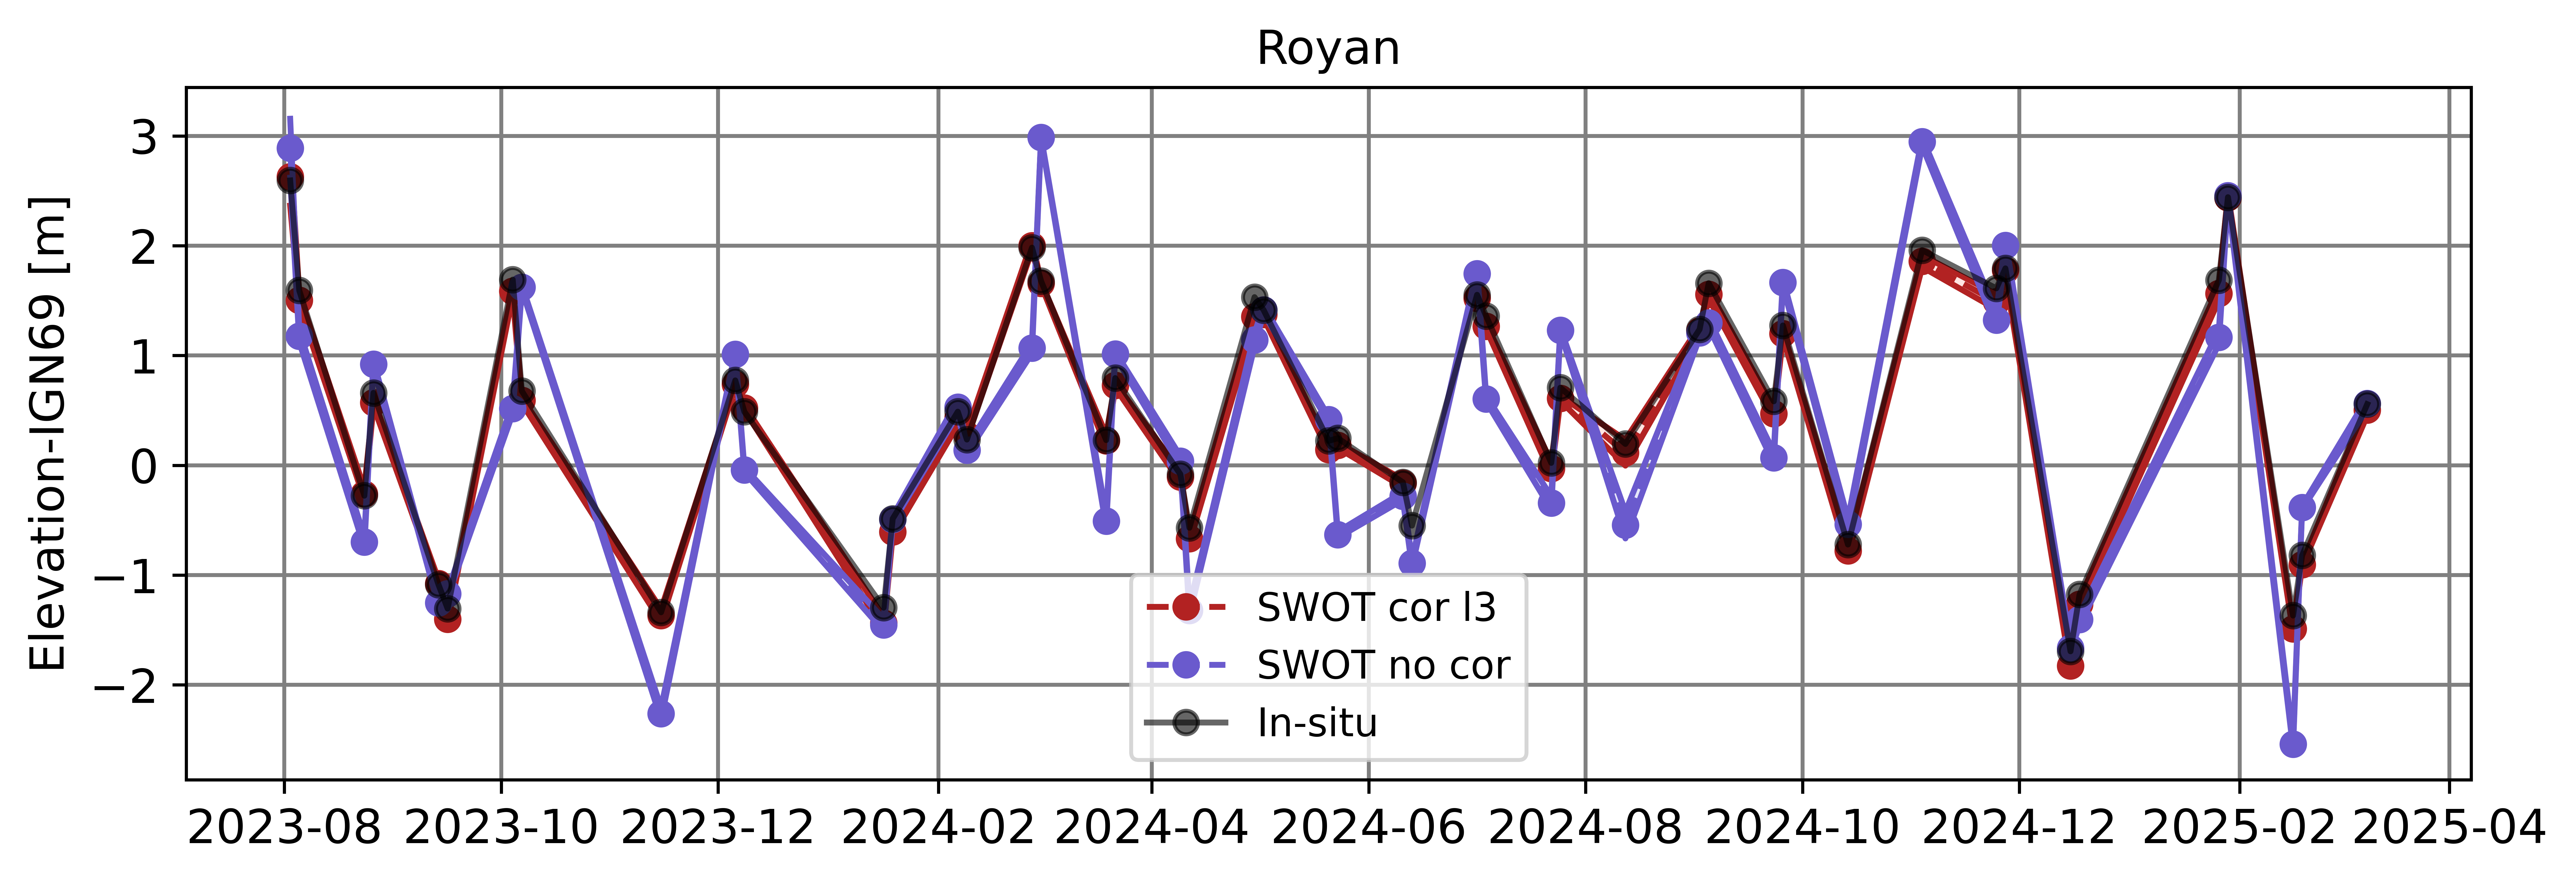

In [40]:
# Plot time series
time_swot_diff=time_swot
moy_diff_swot=list(np.array(swot_cor))
list1_diff_swot=list(np.array(moy_diff_swot)+np.array(std_cor))
list2_diff_swot=list(np.array(moy_diff_swot)-np.array(std_cor))

moy_diff_swot_nocor=list(swot_nocor)
list1_diff_swot_nocor=list(np.array(swot_nocor)+np.array(std_nocor))
list2_diff_swot_nocor=list(np.array(swot_nocor)-np.array(std_nocor))
time_swot_diff_nocor=time_swot
insitu_time_swot=insitu

fig1, ax1 = plt.subplots(layout='constrained', figsize=(9,3),dpi=1000)


ax1.plot(time_swot_diff,list1_diff_swot,color='firebrick')
ax1.plot(time_swot_diff,list2_diff_swot,color='firebrick')
ax1.plot(time_swot_diff,moy_diff_swot,color='firebrick',linestyle='--',marker='o',label='SWOT cor l3')
ax1.plot(time_swot_diff_nocor,list1_diff_swot_nocor,color='slateblue')
ax1.plot(time_swot_diff_nocor,list2_diff_swot_nocor,color='slateblue')
ax1.plot(time_swot_diff_nocor,moy_diff_swot_nocor,color='slateblue',linestyle='--',marker='o',label='SWOT no cor')
time_swot=np.array(time_swot)
list1_diff_swot=np.array(list1_diff_swot)
list2_diff_swot=np.array(list2_diff_swot)
ax1.fill_between(time_swot_diff,list2_diff_swot,list1_diff_swot,color='mistyrose',alpha=1)
ax1.fill_between(time_swot_diff_nocor,list2_diff_swot_nocor,list1_diff_swot_nocor,color='lavender',alpha=1)
ax1.plot(time_swot,insitu_time_swot, color='black',marker='o',label='In-situ',alpha=0.6)

#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.set_ylabel(r"Elevation-IGN69 [m]",fontsize=12)
#ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"Royan")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
#fig1.autofmt_xdate(rotation=30)
#plt.savefig(f'./Images/royan_comp_bis.png')
plt.show()

#### 5.2 Global Statistics (RMSE)

In [41]:
# Remove outliers in the difference between calibrated SWOT and in-situ data
# Compute the difference between calibrated SWOT and in-situ data
diff=np.array(swot_cor)-np.array(insitu)
# All variables must be arrays and not a list
swot_cor=np.array(swot_cor)
swot_nocor=np.array(swot_nocor)
time_swot=np.array(time_swot)
insitu=np.array(insitu)
std_cor=np.array(std_cor)
std_nocor=np.array(std_nocor)
tracks=np.array(tracks)
# Remove outliers
mask=np.where((diff>-0.5) & (diff<0.5))
swot_cor=swot_cor[mask]
swot_nocor=swot_nocor[mask]
time_swot=time_swot[mask]
std_cor=std_cor[mask]
std_nocor=std_nocor[mask]
tracks=tracks[mask]
insitu=insitu[mask]

In [49]:
# Compute RMSE
RMSE_cor=rmse(swot_cor,insitu)
RMSE_nocor=rmse(swot_nocor, insitu)
RMSE_cor=f"{RMSE_cor:.4f}"
RMSE_nocor=f"{RMSE_nocor:.4f}"
RMSE_cor, RMSE_nocor

('0.0804', '0.5491')

In [50]:
# Create data_frame
time=list(time_swot)+list(time_swot)
swot=list(swot_nocor)+list(swot_cor)
insitu_bis=list(insitu)+list(insitu)
tracks_bis=list(tracks)+list(tracks)
label=len(list(swot_cor))*["SWOT nocor"]+len(list(swot_cor))*["SWOT cor l3"]
label1=f"nocor: RMSE={RMSE_cor} [m]"
label2=f"cor l3: RMSE={RMSE_nocor} [m]"
label_bis=len(list(swot_cor))*[label1]+len(list(swot_cor))*[label2]

# Création du DataFrame
df_swot = pd.DataFrame({
    'temps': time,
    'swot': swot,
    'insitu': insitu_bis,
    'Pass': tracks_bis,
    'label': label,
    'label_bis':label_bis
})

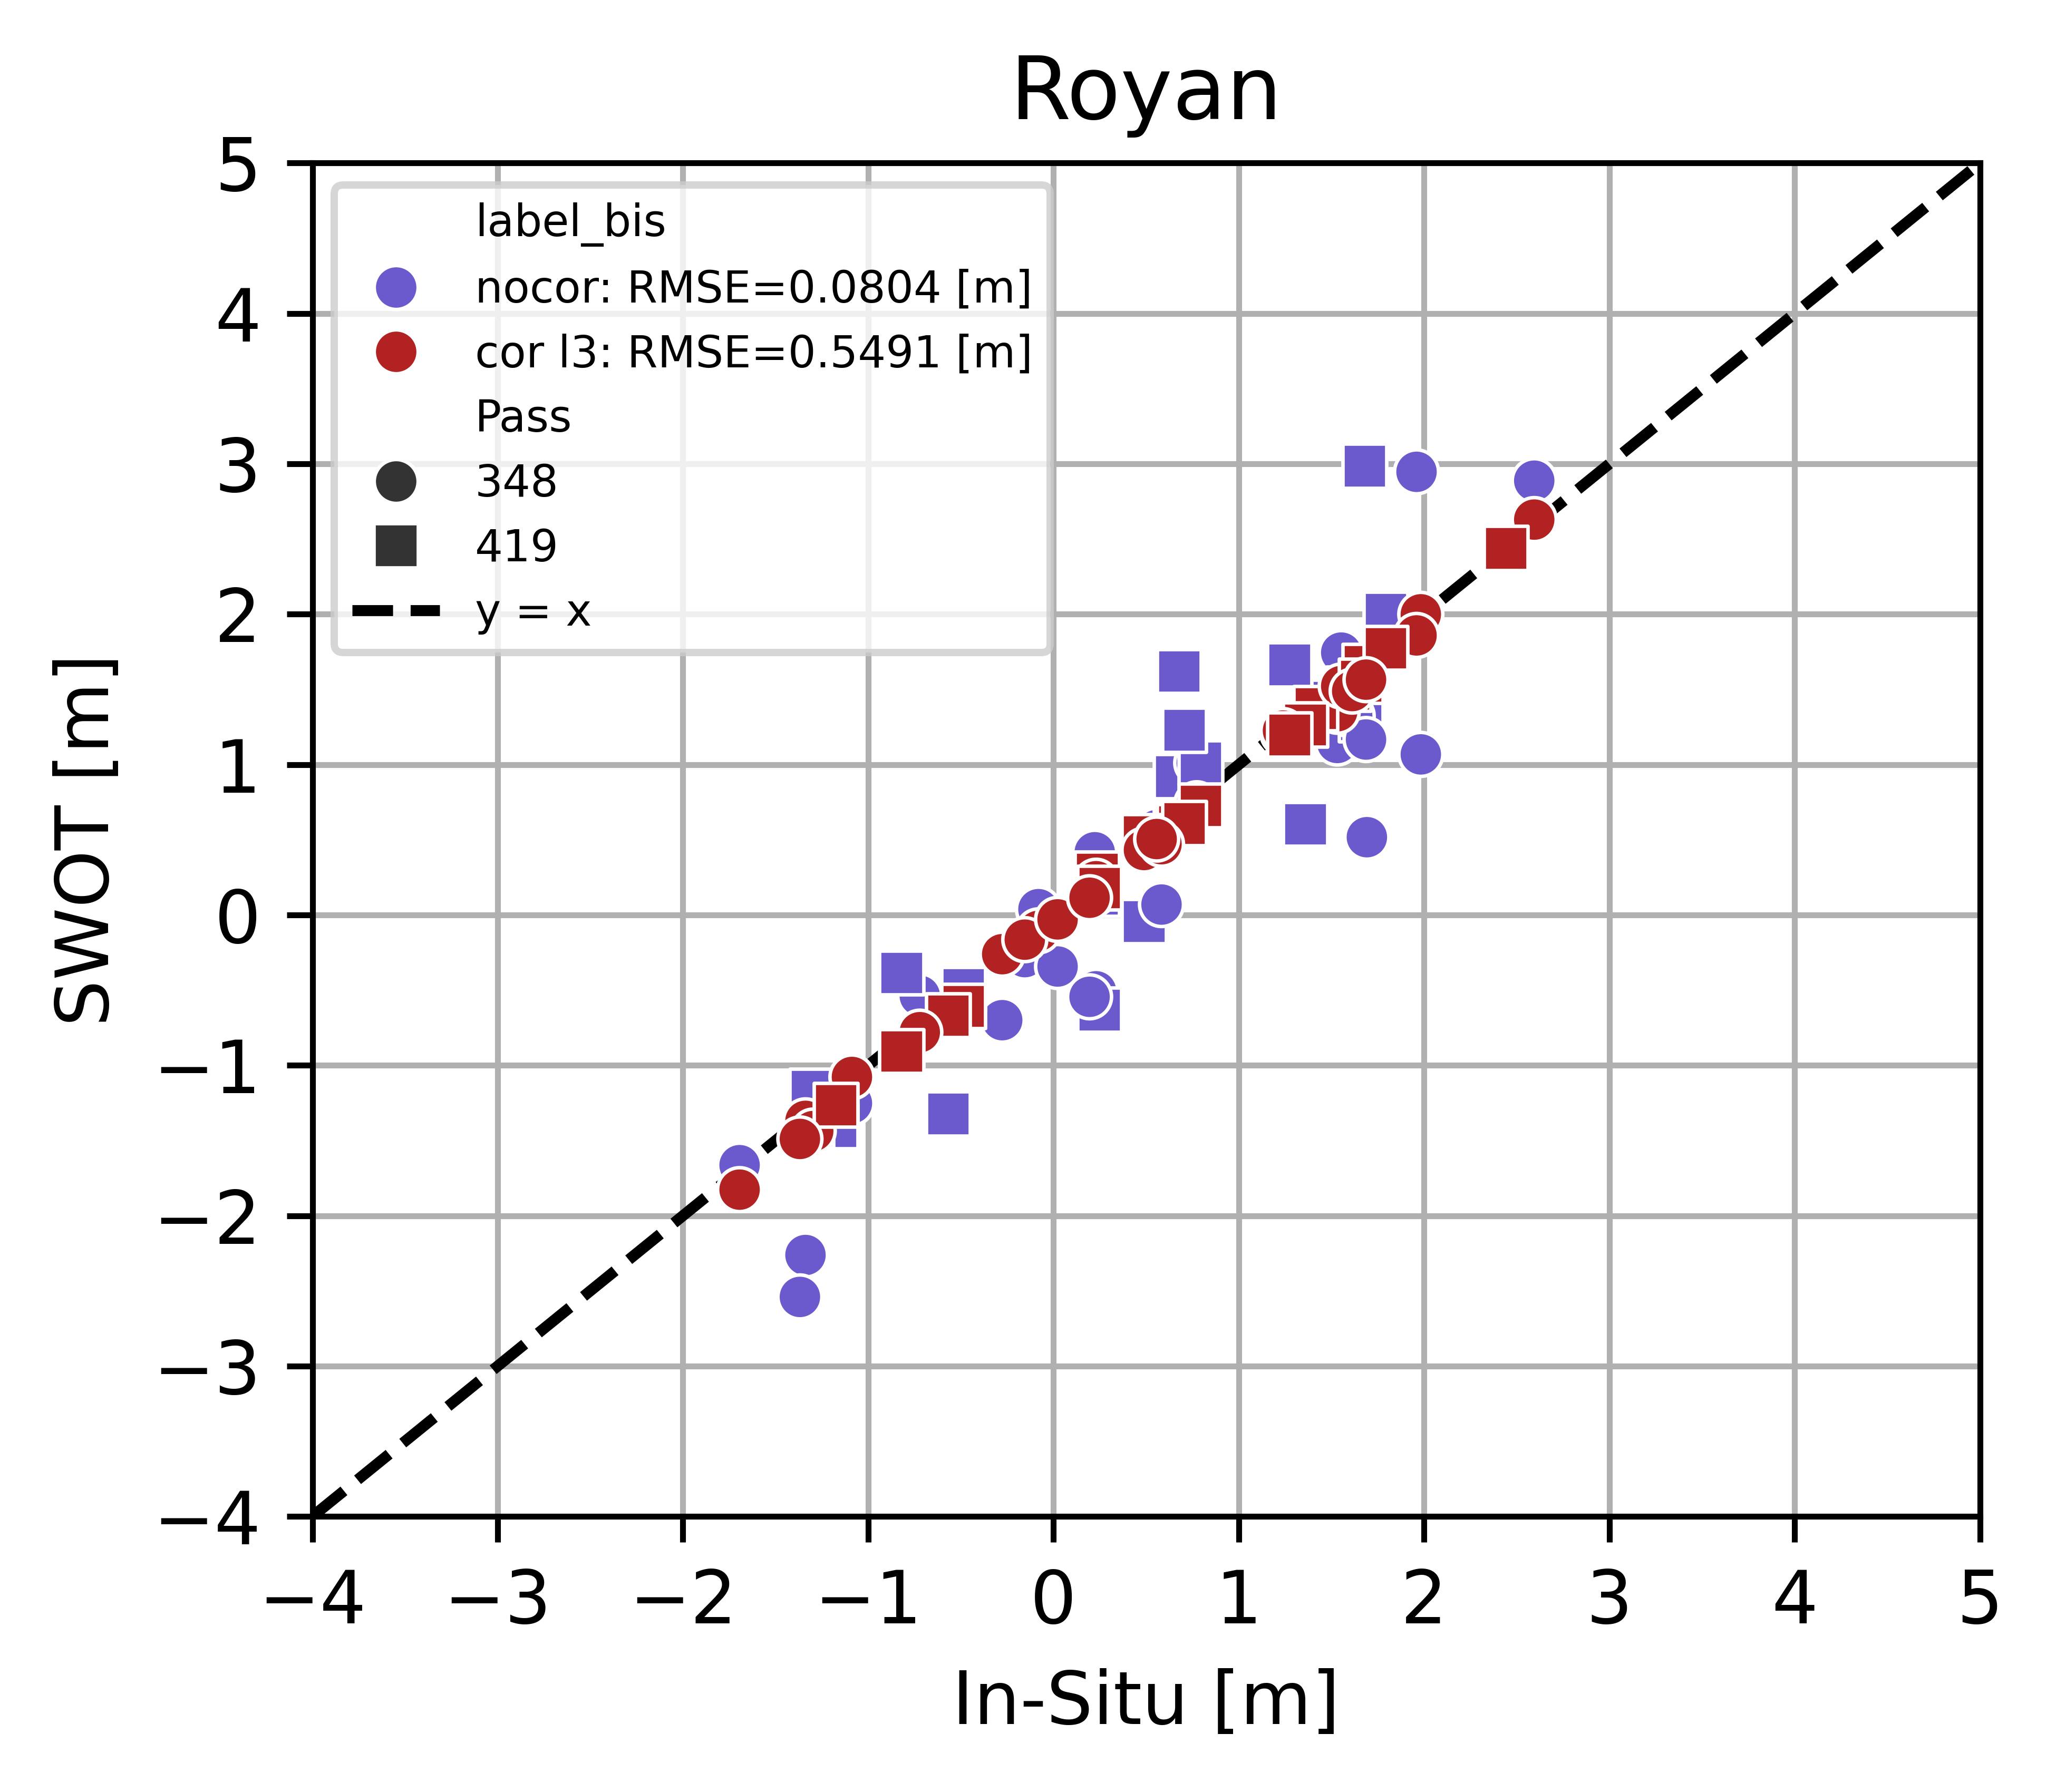

In [52]:
# Plot scatter
palette = {
    "SWOT cor l3": 'firebrick',
    "SWOT nocor": 'slateblue'
}

palette = {
    label2: 'firebrick',
    label1: 'slateblue'
}

marker = {
    348: "o",
    113: "D",
    419: "s",
}

plt.figure(figsize=(4, 3.5), dpi=1000)

# Grille derrière
plt.grid(True, zorder=0)

# Scatterplot
sns.scatterplot(
    data=df_swot,
    x='insitu',
    y='swot',
    hue='label_bis',
    style="Pass",
    palette=palette,
    markers=marker,
    zorder=3
)

# Tracer la diagonale noire
plt.plot([-4, 5], [-4, 5], color='black', linestyle='--', label='y = x', zorder=2)

# Même ticks et limites sur X et Y
ticks = np.arange(-4, 5.1, 1)  # Pas de 1, ajustable
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlim(-4, 5)
plt.ylim(-4, 5)

plt.xlabel('In-Situ [m]')
plt.ylabel('SWOT [m]')
plt.title('Royan')
plt.legend(fontsize=6)
plt.tight_layout()
#plt.savefig(f'./Images/royan_scatter.png')
plt.show()

#### 5.3 Mean and std statistics per pass

In [54]:
# Compute difference in the dataframe
df_swot["diff"]=df_swot["swot"]-df_swot["insitu"]
# Choose only calibrated SWOT
df_cor=df_swot[df_swot["label"]=="SWOT cor l3"]
df_cor

,temps,swot,insitu,Pass,label,label_bis,diff
46,2023-08-02 15:18:15.244970752,2.628966,2.594352,348,SWOT cor l3,cor l3: RMSE=0.5491 [m],0.034614
47,2023-08-05 04:37:49.566540544,1.503193,1.591957,419,SWOT cor l3,cor l3: RMSE=0.5491 [m],-0.088763
48,2023-08-23 12:03:20.085709312,-0.261025,-0.277006,348,SWOT cor l3,cor l3: RMSE=0.5491 [m],0.015981
49,2023-08-26 01:22:53.922241536,0.571033,0.659535,419,SWOT cor l3,cor l3: RMSE=0.5491 [m],-0.088501
50,2023-09-13 08:48:26.480235264,-1.077421,-1.088077,348,SWOT cor l3,cor l3: RMSE=0.5491 [m],0.010656
51,2023-09-15 22:08:00.454515968,-1.400821,-1.305286,419,SWOT cor l3,cor l3: RMSE=0.5491 [m],-0.095534
52,2023-10-04 05:33:28.265462016,1.584904,1.691083,348,SWOT cor l3,cor l3: RMSE=0.5491 [m],-0.106179
53,2023-10-06 18:53:01.510833664,0.591341,0.676479,419,SWOT cor l3,cor l3: RMSE=0.5491 [m],-0.085138
54,2023-11-14 23:03:38.312079360,-1.369220,-1.338747,348,SWOT cor l3,cor l3: RMSE=0.5491 [m],-0.030473
55,2023-12-05 19:48:43.852752128,0.739418,0.772985,348,SWOT cor l3,cor l3: RMSE=0.5491 [m],-0.033566


In [55]:
# Global statistics of the difference between SWOT and insitu
mean=df_cor["diff"].mean()
std=df_cor["diff"].std()
mean,std

(-0.06165590121288136, 0.05211858952574941)

In [56]:
# Statistics per pass
result = df_cor.groupby('Pass')['diff'].agg(['mean', 'std'])
result

,mean,std
Pass,,
348,-0.06073,0.057077
419,-0.06286,0.046305
